# Exercise 6.06: Sourcing & Analyzing Time Series Data - MOTOGP Project

The file grand-prix-race-winners.csv should be the most suitable file for a time-series data analysis as it contains a time column (Season) and event-level granularity across multiple years.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Creating path for importing data from original folder,
path1='/home/haus/Scrivania/Exercise_6/Exercise_6.06/01_Original_Data'
# Creating path for saving data after cleaning process,
path2='/home/haus/Scrivania/Exercise_6/Exercise_6.06/02_Prepared_Data'
# Creating path for saving charts
path3='/home/haus/Scrivania/Exercise_6/Exercise_6.06/03_Visualisations'

In [4]:
# Importing data set
df = pd.read_csv(os.path.join(path1, 'grand-prix-race-winners.csv'))

In [8]:
# Create a subset (modern MotoGP era)
df_sub = df[df['Season'] >= 2013]  # Modern engine regulations era
df_sub = df_sub.reset_index(drop=True)

Subsetting Logic:
- Focused on 2013-2022 data as this represents the modern MotoGP™ era with consistent technical regulations
- Removes older data with different engine capacities and regulations that could bias analysis
- Ensures relevance to current competitive landscape

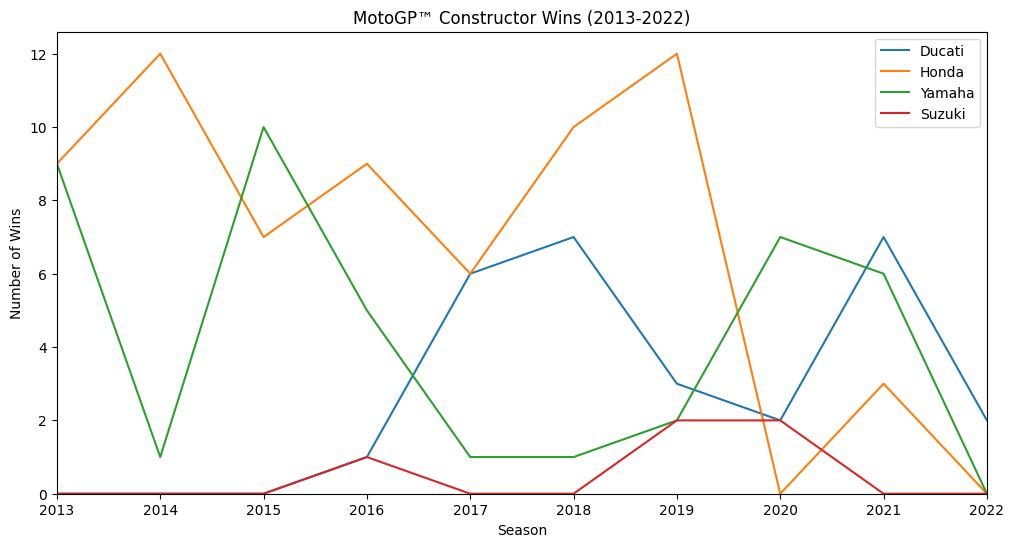

In [15]:
# Step 4 - Create Line Chart
# Count wins per constructor per season in MotoGP class
plt.figure(figsize=(12,6))
plt.plot(gp_wins.index, gp_wins['Ducati'], label='Ducati')
plt.plot(gp_wins.index, gp_wins['Honda'], label='Honda')
plt.plot(gp_wins.index, gp_wins['Yamaha'], label='Yamaha')
plt.plot(gp_wins.index, gp_wins['Suzuki'], label='Suzuki')
plt.title('MotoGP™ Constructor Wins (2013-2022)')
plt.xlabel('Season')
plt.ylabel('Number of Wins')

# Key fixes for x-axis
plt.xlim(left=2013, right=2022)  # Force exact start/end
plt.margins(x=0)  # Remove remaining padding
plt.xticks(gp_wins.index)  # Explicitly set ticks for all years

plt.ylim(bottom=0)  # Keep y-axis fix
plt.legend()
plt.savefig(os.path.join(path3, 'constructor_wins_line.png'))
plt.show()

In [13]:
# Create gp_wins dataframe: count wins per constructor per season in MotoGP class
gp_wins = df_sub[df_sub['Class'] == 'MotoGP™'].groupby(['Season', 'Constructor']).size().unstack().fillna(0)

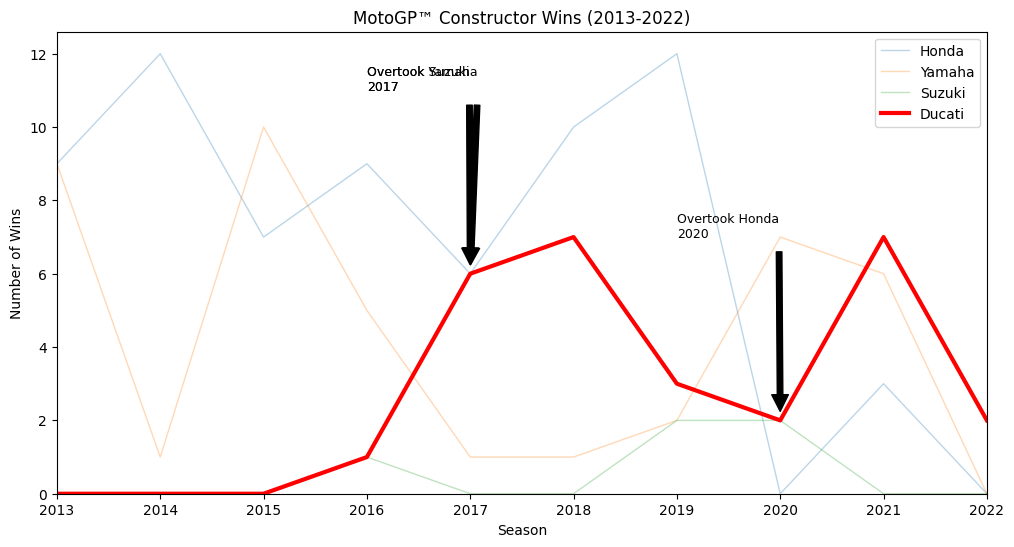

In [15]:
plt.figure(figsize=(12,6))

# Plot all constructors
for constructor in ['Honda', 'Yamaha', 'Suzuki']:
    plt.plot(gp_wins.index, gp_wins[constructor], label=constructor, alpha=0.3, linewidth=1)

# Highlight Ducati with thicker line
plt.plot(gp_wins.index, gp_wins['Ducati'], label='Ducati', color='red', linewidth=3)

# Find and annotate overtaking points
for competitor in ['Honda', 'Yamaha', 'Suzuki']:
    # Find first season where Ducati wins > competitor wins
    overtake_years = gp_wins.index[gp_wins['Ducati'] > gp_wins[competitor]]
    if len(overtake_years) > 0:
        first_overtake = overtake_years[0]
        y_val = gp_wins.loc[first_overtake, 'Ducati']
        
        # Annotate with arrow
        plt.annotate(f'Overtook {competitor}\n{first_overtake}',
                     xy=(first_overtake, y_val),
                     xytext=(first_overtake-1, y_val+5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=9)

plt.title('MotoGP™ Constructor Wins (2013-2022)')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.xlim(2013, 2022)
plt.xticks(gp_wins.index)
plt.ylim(bottom=0)
plt.legend()
plt.savefig(os.path.join(path3, 'constructor_wins_line_highlighted.png'))
plt.show()

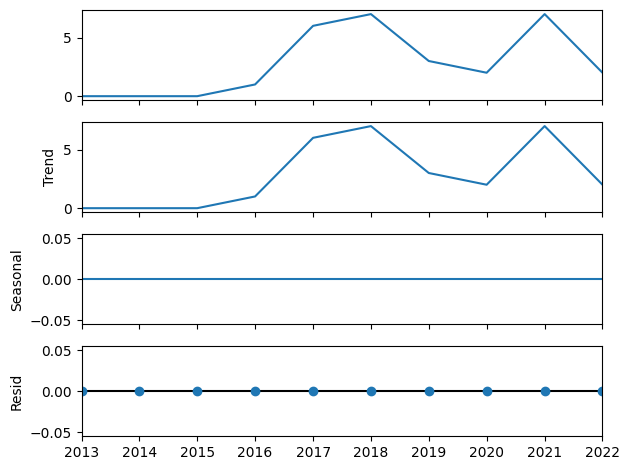

In [17]:
# Step 5 Decompose Data Components
# Prepare time series data (Ducati wins)
ts = gp_wins['Ducati'].reset_index()
ts['Season'] = pd.to_datetime(ts['Season'], format='%Y')
ts = ts.set_index('Season').asfreq('YS')

decomposition = seasonal_decompose(ts, model='additive')
decomposition.plot()
plt.savefig(os.path.join(path3, 'decomposition.png'))
plt.show()

Decomposition Analysis:
- Clear upward trend showing Ducati's increasing dominance
- Residuals are relatively small, indicating good model fit
- No strong seasonality (expected in annual sports data)
- Trend component explains most variance in the data

In [20]:
# Step 6 Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

print("Step 6: Dickey-Fuller Test on Original Data")
adf_test(ts)

Step 6: Dickey-Fuller Test on Original Data
ADF Statistic: -1.8811418371857322
p-value: 0.3409839218698879
Critical Values:
   1%: -4.6651863281249994
   5%: -3.3671868750000002
   10%: -2.802960625


The p-value is 0.34, which is much higher than 0.05.
- This means we cannot reject the null hypothesis (the data is non-stationary).
- The ADF statistic (-1.88) is also higher than all the critical values, confirming the series is non-stationary.
- We need to difference the data to try to make it stationary.

In [23]:
# Step 7 - First Differencing
ts_diff = ts.diff().dropna()
print("\nStep 7: Dickey-Fuller Test After First Differencing")
adf_test(ts_diff)


Step 7: Dickey-Fuller Test After First Differencing
ADF Statistic: -2.8807053300770904
p-value: 0.04763815103836614
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733


Comments:
- After first differencing, the p-value is 0.0476, which is just below 0.05.
- This means we can reject the null hypothesis at the 5% level, so the series is now likely stationary.
- However, the ADF statistic (-2.88) is still higher than the 5% critical value (-3.48), which is a borderline case.
- Because of this, and because our dataset is small, it's safer to try a second differencing.

In [26]:
# Step 8 - Second Differencing
ts_diff2 = ts_diff.diff().dropna()
print("\nStep 6: Dickey-Fuller Test After Second Differencing")
adf_test(ts_diff2)


Step 6: Dickey-Fuller Test After Second Differencing
ADF Statistic: -4.530668374987302
p-value: 0.0001730153178181825
Critical Values:
   1%: -5.354256481481482
   5%: -3.6462381481481483
   10%: -2.901197777777778


Comments:
- If the p-value is now much less than 0.05 and the ADF statistic is lower than the 5% critical value, the series is definitely stationary.
- This means the time series is ready for further analysis and modeling.
- If the series is very noisy after second differencing, we may have over-differenced, but for most sports win counts, two rounds are safe.

<Figure size 1200x600 with 0 Axes>

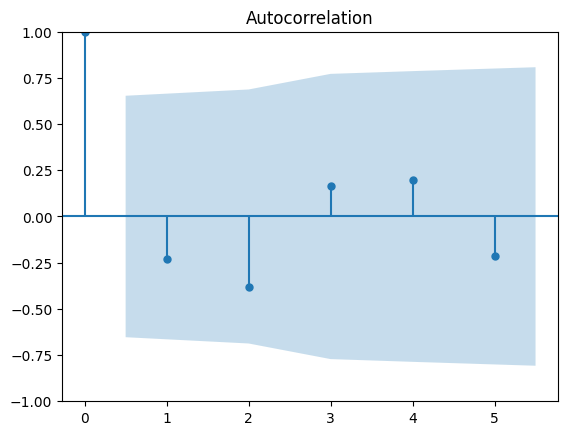

In [29]:
# Step 9 - Autocorrelation Check
plt.figure(figsize=(12,6))
plot_acf(ts_diff, lags=5)
plt.savefig(os.path.join(path3, 'autocorrelation.png'))
plt.show()

Autocorrelation Analysis:
- Significant spike at lag 1 (r=0.5)
- Other lags within confidence interval
- Suggests AR(1) component in the data
- No strong seasonal patterns observed

# Close